## Goals: Training the *Final* Models

This notebook trains the model on the full *baseline_dataset* for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic *regions*.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.

In [8]:
%load_ext autoreload
%autoreload 2

import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import json
import matplotlib.pyplot as plt
from codecarbon import EmissionsTracker

from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from quantile_forest import RandomForestQuantileRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, WhiteKernel,Matern, ConstantKernel as C
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

from src.utils.custom_models import VotingRandomForestQuantileRegressor
from src.utils.model import split_dataset, compare_models_per_station, XGBQRFModel, ChainedQrfModel, SpecialistQrfModel, XGBQRF_SimpleModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##### Constants :
- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.

In [9]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

DATASET_TRANSFORMS = [
    "rm_gnv_st",
    "pca",
    "snow_index",
    # "oh_enc_date",
    "cyc_enc_date",
    "clust_index",
    "clust_hydro",
    # "scl_feat",
    "scl_feat_wl", # Scale all except waterflow lag
    # "scl_catch",
    # "rm_wl", # remove custom generated water_flow_lag 3w & 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "slct_ma", # keep only specific mobile average 2w or/and 3w or/and 4w ---> Need USE_CUSTOM_PREPROCESS = True
    "lag_slope", # add an indicator that is calculated between water_flow_lag 1w and 2w 
    # "scl_by_clust"
]

DATASET_SPEC = "_".join(DATASET_TRANSFORMS)

DATASET_SPEC = "dataset_custom_rendu_final"

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4

FINAL_MODELS = [
                # "qrf_bagging",
                "qrf_voting",
                "qrf",
                # "chained_qrf",
                "quantile_xgb_qrf",
                # "native_xgb_qrf",
                # "gbr",
                # "gpr"
                # "specialized_qrf"
                ]

gpr = {}
qrf = {}
chained_qrf = None
qrf_bagging = {}
qrf_voting = {}
gbr = {}

COLUMNS_TO_DROP = ["water_flow_week1", "water_flow_week2", "water_flow_week3", "water_flow_week4"]

USE_ONLY_BEST_FEATURES = False
USE_CORRELATED_FEATURES = False

BEST_FEATURES = [
    "precipitations_lag_1w_pca_2",
    "precipitations_pca_1",
    "precipitations_pca_2",
    "tempartures_lag_1w_pca_1",
    "tempartures_pca_1",
    "soil_moisture_pca_1",
    "soil_moisture_pca_2",
    "soil_moisture_pca_3",
    "evaporation_lag_1w_pca_1",
    "evaporation_pca_1",
    "soil_composition_pca_1",
    "soil_composition_pca_4",
    "soil_composition_pca_6",
    "soil_composition_pca_7",
    "latitude",
    "longitude",
    "catchment",
    "altitude",
    "water_flow_lag_1w",
    "water_flow_lag_2w",
    "water_flow_ma_4w_lag_1w_gauss",
    "north_hemisphere",
    "snow_index",
    "month_cos"
]

PERMANENT_FEATURES = [
    "latitude",
    "longitude",
    "altitude",
    "catchment",
    "north_hemisphere",
    "month_sin",
    "month_cos",
    "season_sin",
    "season_cos",
    "region_cluster",
    "hydro_cluster",
    # "water_flow_evolve_slope",
]

if USE_CORRELATED_FEATURES: 
    path = f"../00 Preprocessing/correlation_outputs/strong_correlations_{DATASET_SPEC}.json"

    with open(path, 'r') as file:
        correlated_features = json.load(file)


### 2. Data Loading
Load in the baseline datasets, create the directory to save models.

In [10]:
dataset_train = pd.read_csv(f"{INPUT_DIR}{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

Data pre-processing removal of unnecessary columns, setup of the target

In [11]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)
y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train[i] = dataset_train[f"water_flow_week{i+1}"]


### 2. Models training
#### a. QRF Bagging

In [12]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

- **Data Preparation:**  
  - Splits `dataset_train` into training and validation subsets using `split_dataset`.
  - Removes unnecessary columns from both the training and validation datasets.
  - Extracts target variables for each week (from `water_flow_week1` to `water_flow_week4`).


In [13]:
if "qrf_bagging" in FINAL_MODELS:

    print("Training qrf_bagging")

    initial_model = RandomForestQuantileRegressor(n_estimators= 25, min_samples_split=9, min_samples_leaf=11, max_features= None, max_depth= 30, bootstrap=True)
    train_qrf_bagging, val_qrf_bagging, val_temporal  = split_dataset(dataset_train, 0.75, TIME_VALIDATION)    

    X_train_qrf_bagging = train_qrf_bagging.drop(columns=["station_code"])
    print(len(X_train_qrf_bagging.columns))
    y_train_qrf_bagging = {}
    for i in range(0, NUMBER_OF_WEEK):
        y_train_qrf_bagging[i] = train_qrf_bagging[f"water_flow_week{i+1}"]

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        # Initialize and train Model
        qrf_bagging[i] = BaggingRegressor(estimator=initial_model, n_estimators=3, random_state=0)
        qrf_bagging[i].fit(X_train_qrf_bagging, y_train_qrf_bagging[i])
        
        # save model with date
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

        model_path = f"{MODEL_DIR}final/qrf_bagging_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf_bagging[i], model_path)


#### b. QRF Voting


In [14]:
if "qrf_voting" in FINAL_MODELS:
    tracker = EmissionsTracker(output_file="qrf_voting_emissions.csv")
    tracker.start()


    VARIANTS = [
            "full_model_remove_station_identication",
            "france_remove_station_identication",
            "brazil_remove_station_identication",
            # "full_model",
            # "france_model",
            # "brazil_model",
        ]
    print("Training qrf_voting")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        qrf_voting[i] = VotingRandomForestQuantileRegressor(VARIANTS)

        X_train_qrf_voting = X_train.copy() 
        print(len(X_train_qrf_voting.columns))
        if USE_CORRELATED_FEATURES:
            X_train_qrf_voting = X_train_qrf_voting[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"] + ["station_code"]]
            print(len(X_train_qrf_voting.columns))

        qrf_voting[i].fit(X_train_qrf_voting, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_voting_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf_voting[i], model_path)


    tracker.stop()
    emissions_qrf_voting = tracker.final_emissions_data
    print(emissions_qrf_voting)


[codecarbon WARNING @ 10:12:24] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:12:24] [setup] RAM Tracking...
[codecarbon INFO @ 10:12:25] [setup] CPU Tracking...
[codecarbon WARNING @ 10:12:26] We saw that you have a 12th Gen Intel(R) Core(TM) i5-12450H but we don't know it. Please contact us.
[codecarbon WARNING @ 10:12:26] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:12:26] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i5-12450H
[codecarbon WARNING @ 10:12:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:12:26] [setup] GPU Tracking...
[codecarbon INFO @ 10:12:26] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:12:26] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Track

Training qrf_voting
Training week 0
42
Training for variant full_model_remove_station_identication
Training on 27702 samples


[codecarbon INFO @ 10:12:46] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:12:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:12:46] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:12:46] Energy consumed for all GPUs : 0.000022 kWh. Total GPU Power : 5.175075498288429 W
[codecarbon INFO @ 10:12:46] 0.000241 kWh of electricity used since the beginning.


Training for variant france_remove_station_identication
Training on 21141 samples


[codecarbon INFO @ 10:13:01] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:13:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:13:01] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:13:01] Energy consumed for all GPUs : 0.000047 kWh. Total GPU Power : 6.147517004650753 W
[codecarbon INFO @ 10:13:01] 0.000485 kWh of electricity used since the beginning.


Training for variant brazil_remove_station_identication
Training on 6561 samples
Training week 1
42
Training for variant full_model_remove_station_identication
Training on 27702 samples


[codecarbon INFO @ 10:13:16] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:13:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:13:16] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 10:13:16] Energy consumed for all GPUs : 0.000059 kWh. Total GPU Power : 2.8153122336001677 W
[codecarbon INFO @ 10:13:16] 0.000715 kWh of electricity used since the beginning.


Training for variant france_remove_station_identication
Training on 21141 samples


[codecarbon INFO @ 10:13:31] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:13:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:13:31] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 10:13:31] Energy consumed for all GPUs : 0.000071 kWh. Total GPU Power : 2.867545409869058 W
[codecarbon INFO @ 10:13:31] 0.000946 kWh of electricity used since the beginning.


Training for variant brazil_remove_station_identication
Training on 6561 samples
Training week 2
42
Training for variant full_model_remove_station_identication
Training on 27702 samples


[codecarbon INFO @ 10:13:46] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:13:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:13:46] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 10:13:46] Energy consumed for all GPUs : 0.000083 kWh. Total GPU Power : 2.816589187867267 W
[codecarbon INFO @ 10:13:46] 0.001176 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:01] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:14:01] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:14:01] Energy consumed for All CPU : 0.001062 kWh
[codecarbon INFO @ 10:14:01] Energy consumed for all GPUs : 0.000096 kWh. Total GPU Power : 3.246383266383811 W
[codecarbon INFO @ 10:14:01] 0.001408 kWh of electricity used since the beginning.


Training for variant france_remove_station_identication
Training on 21141 samples


[codecarbon INFO @ 10:14:16] Energy consumed for RAM : 0.000291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:14:16] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:14:16] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 10:14:16] Energy consumed for all GPUs : 0.000110 kWh. Total GPU Power : 3.3987553008822258 W
[codecarbon INFO @ 10:14:16] 0.001641 kWh of electricity used since the beginning.


Training for variant brazil_remove_station_identication
Training on 6561 samples
Training week 3
42
Training for variant full_model_remove_station_identication
Training on 27702 samples


[codecarbon INFO @ 10:14:31] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:14:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:14:31] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 10:14:31] Energy consumed for all GPUs : 0.000126 kWh. Total GPU Power : 3.7164691715142375 W
[codecarbon INFO @ 10:14:31] 0.001876 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:14:31] 0.000037 g.CO2eq/s mean an estimation of 1.171269374629509 kg.CO2eq/year


Training for variant france_remove_station_identication
Training on 21141 samples


[codecarbon INFO @ 10:14:46] Energy consumed for RAM : 0.000375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:14:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:14:46] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 10:14:46] Energy consumed for all GPUs : 0.000136 kWh. Total GPU Power : 2.5233509588615206 W
[codecarbon INFO @ 10:14:46] 0.002105 kWh of electricity used since the beginning.


Training for variant brazil_remove_station_identication
Training on 6561 samples


[codecarbon INFO @ 10:14:56] Energy consumed for RAM : 0.000401 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:14:56] Delta energy consumed for CPU with constant : 0.000113 kWh, power : 42.5 W
[codecarbon INFO @ 10:14:56] Energy consumed for All CPU : 0.001707 kWh
[codecarbon INFO @ 10:14:56] Energy consumed for all GPUs : 0.000152 kWh. Total GPU Power : 5.799702933316525 W
[codecarbon INFO @ 10:14:56] 0.002260 kWh of electricity used since the beginning.


EmissionsData(timestamp='2025-05-15T10:14:56', project_name='codecarbon', run_id='043c99cb-1d01-4cea-aa42-15c5f0631926', experiment_id='5b0fa12a-3dd7-45bb-9766-cc326314d9f1', duration=144.6197049000766, emissions=5.3718229826784926e-06, emissions_rate=3.7144474789172706e-08, cpu_power=42.5, gpu_power=5.799702933316525, ram_power=10.0, cpu_energy=0.0017067546005575826, gpu_energy=0.00015173178805200083, ram_energy=0.0004012228711107228, energy_consumed=0.0022597092597203064, country_name='Canada', country_iso_code='CAN', region='quebec', cloud_provider='', cloud_region='', os='Windows-11-10.0.26100-SP0', python_version='3.12.2', codecarbon_version='3.0.0', cpu_count=12, cpu_model='12th Gen Intel(R) Core(TM) i5-12450H', gpu_count=1, gpu_model='1 x NVIDIA GeForce RTX 4060 Laptop GPU', longitude=-71.2, latitude=46.8, ram_total_size=15.693840026855469, tracking_mode='machine', on_cloud='N', pue=1.0)


#### c. GradientBoostingRegressor

In [15]:
if "gbr" in FINAL_MODELS:
    gbr = {}
    X_train_gbr = X_train.drop(columns=["station_code"])
    print("Training GradientBoostingRegressor")

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")

        gbr[i] = {}
        common_params = dict(
            learning_rate=0.05,
            n_estimators=200,
            max_depth=2,
            min_samples_leaf=9,
            min_samples_split=9,
        )
        
        for alpha in [0.05, 0.5, 0.95]:
            print(f"Training quantile {alpha}")
            gbr_model = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
            key = "lower" if alpha == 0.05 else "median" if alpha == 0.5 else "upper"
            gbr[i][key] = gbr_model.fit(X_train_gbr, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/gbr_quantile_{time}_week_{i}.pkl"
        joblib.dump(gbr[i], model_path)
    

#### d. QRF 

In [16]:
X_train_qrf = X_train.copy().drop(columns=["station_code"])

if "qrf" in FINAL_MODELS:
    tracker = EmissionsTracker(output_file="qrf_emissions.csv")
    tracker.start()
    
    if USE_ONLY_BEST_FEATURES:
        print(X_train_qrf.shape)
        X_train_qrf = X_train_qrf[BEST_FEATURES]
        print(X_train_qrf.shape)

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor
        
        # n_estimators=135, min_samples_split=27, min_samples_leaf=27, max_features=None, max_depth=30, bootstrap=True
        # n_estimators=85, min_samples_split=80, min_samples_leaf=15, max_features=None, max_depth=13, bootstrap=True
        # n_estimators=25, min_samples_split=11, min_samples_leaf=27, max_features=None, max_depth=48, bootstrap=True
        
        X_train_qrf =  X_train.drop(columns=["station_code"])
        print(len(X_train_qrf.columns))
        if USE_CORRELATED_FEATURES:
            X_train_qrf = X_train_qrf[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"]]
            print(len(X_train_qrf.columns))
        
        qrf[i] = RandomForestQuantileRegressor(n_estimators=25, min_samples_split=11, min_samples_leaf=27, max_features=None, max_depth=48, bootstrap=True,random_state=SEED)
        qrf[i].fit(X_train_qrf, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)
    
    tracker.stop()
    emissions_qrf = tracker.final_emissions_data
    print(emissions_qrf)


[codecarbon WARNING @ 10:14:56] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:14:56] [setup] RAM Tracking...
[codecarbon INFO @ 10:14:56] [setup] CPU Tracking...
[codecarbon WARNING @ 10:14:58] We saw that you have a 12th Gen Intel(R) Core(TM) i5-12450H but we don't know it. Please contact us.
[codecarbon WARNING @ 10:14:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:14:58] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i5-12450H
[codecarbon WARNING @ 10:14:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:14:58] [setup] GPU Tracking...
[codecarbon INFO @ 10:14:58] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:14:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Track

Training week 0
41
Training week 1
41


[codecarbon INFO @ 10:15:17] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:15:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:15:17] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:15:17] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 3.281450759256732 W
[codecarbon INFO @ 10:15:17] 0.000233 kWh of electricity used since the beginning.


Training week 2
41


[codecarbon INFO @ 10:15:32] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:15:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:15:32] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:15:32] Energy consumed for all GPUs : 0.000030 kWh. Total GPU Power : 4.017925027147266 W
[codecarbon INFO @ 10:15:32] 0.000468 kWh of electricity used since the beginning.


Training week 3
41


[codecarbon INFO @ 10:15:47] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:15:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:15:47] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 10:15:47] Energy consumed for all GPUs : 0.000050 kWh. Total GPU Power : 4.804037408012424 W
[codecarbon INFO @ 10:15:47] 0.000707 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:15:56] Energy consumed for RAM : 0.000152 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:15:56] Delta energy consumed for CPU with constant : 0.000116 kWh, power : 42.5 W
[codecarbon INFO @ 10:15:56] Energy consumed for All CPU : 0.000647 kWh
[codecarbon INFO @ 10:15:56] Energy consumed for all GPUs : 0.000068 kWh. Total GPU Power : 6.555601349742704 W
[codecarbon INFO @ 10:15:56] 0.000868 kWh of electricity used since the beginning.


EmissionsData(timestamp='2025-05-15T10:15:56', project_name='codecarbon', run_id='b0534275-43df-42b2-97b3-434288040014', experiment_id='5b0fa12a-3dd7-45bb-9766-cc326314d9f1', duration=54.832339300075546, emissions=4.86188037535226e-05, emissions_rate=8.86681188038527e-07, cpu_power=42.5, gpu_power=6.555601349742704, ram_power=10.0, cpu_energy=0.0006471393801394798, gpu_energy=6.82889435200118e-05, ram_energy=0.0001521603869442414, energy_consumed=0.0008675887106037331, country_name='France', country_iso_code='FRA', region='', cloud_provider='', cloud_region='', os='Windows-11-10.0.26100-SP0', python_version='3.12.2', codecarbon_version='3.0.0', cpu_count=12, cpu_model='12th Gen Intel(R) Core(TM) i5-12450H', gpu_count=1, gpu_model='1 x NVIDIA GeForce RTX 4060 Laptop GPU', longitude=2.3387, latitude=48.8582, ram_total_size=15.693840026855469, tracking_mode='machine', on_cloud='N', pue=1.0)


#### d.1 Chained QRF 

#### Loading params

In [17]:
if "chained_qrf" in FINAL_MODELS:
    #Loading the best parameters from the random search
    BASE_PARAM_PATH = '../02 Exploration/02 - Single model optimisation/search-results/'
    file_path = BASE_PARAM_PATH + "chained_config.json"

    with open(file_path, 'r') as file:
        optimized_params = json.load(file)

    qrf_params = {}
    qrf_features = {}

    index=0

    for key in optimized_params.keys():

        model_params = {
            key.replace('model__', ''): value
            for key, value in optimized_params[key]["best_params"].items()
            if key.startswith('model__')
        }

        qrf_params[index] = model_params
        print(optimized_params[key])
        qrf_features[index] = optimized_params[key]["features_to_train"]
        index+=1

    print(qrf_params)
    print(qrf_features)

In [18]:
if "chained_qrf" in FINAL_MODELS:
    tracker = EmissionsTracker(output_file="chained_qrf_emissions.csv")
    tracker.start()
    X_train_chained_qrf = X_train.drop(columns=["station_code"])
    print("Training Chained QRF")

    quantiles = [0.05, 0.5, 0.95]
    chained_qrf = ChainedQrfModel(qrf_params=qrf_params, qrf_features=qrf_features, number_of_weeks=NUMBER_OF_WEEK)

    chained_qrf.fit(X_train_chained_qrf, y_train)

    time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_path = f"{MODEL_DIR}final/chained_qrf_quantile_{time}_4weeks.pkl"
    joblib.dump(chained_qrf, model_path)

    tracker.stop()
    emissions_qrf_chained = tracker.final_emissions_data
    print(emissions_qrf_chained)

### d.2 Specialized QRF

In [19]:
if "specialized_qrf" in FINAL_MODELS:
    print("Training Specialized QRF")
    quantiles = [0.05, 0.5, 0.95]

    qrf_params = {
        0: {
                "n_estimators": 35,
                "min_samples_split": 60,
                "min_samples_leaf": 9,
                "max_features": None,
                "max_depth": 13,
                "bootstrap": True
        },
        1: {
                "n_estimators": 35,
                "min_samples_split": 60,
                "min_samples_leaf": 9,
                "max_features": None,
                "max_depth": 13,
                "bootstrap": True
        },
        2: {
                "n_estimators": 190,
                "min_samples_split": 105,
                "min_samples_leaf": 80,
                "max_features": "log2",
                "max_depth": 20,
                "bootstrap": False
        }
    }

    qrf_features = {
        0:  [
            "catchment",
            "water_flow_lag_1w",
            "water_flow_ma_4w_lag_1w_gauss"
        ],
        1:  [
                "precipitations_lag_1w_pca_2",
                "precipitations_pca_2",
                "tempartures_lag_1w_pca_1",
                "tempartures_pca_1",
                "soil_moisture_pca_2",
                "soil_moisture_pca_3",
                "soil_composition_pca_1",
                "soil_composition_pca_2",
                "soil_composition_pca_3",
                "soil_composition_pca_4",
                "soil_composition_pca_6",
                "soil_composition_pca_7",
                "soil_composition_pca_9",
                "latitude",
                "longitude",
                "catchment",
                "altitude",
                "water_flow_lag_1w",
                "water_flow_lag_2w",
                "water_flow_ma_4w_lag_1w_gauss",
                "month_cos",
                "season_sin",
                "hydro_cluster"
            ],
        2: [
                "soil_composition_pca_8",
                "soil_composition_pca_9",
                "catchment",
                "water_flow_lag_1w",
                "water_flow_lag_2w",
                "water_flow_ma_4w_lag_1w_gauss"
            ]
    }

    specialized_qrf = SpecialistQrfModel(
        qrf_params=qrf_params,
        qrf_features=qrf_features,
        specialized_col="region_cluster",
        number_of_weeks=NUMBER_OF_WEEK,
        number_of_clusters=10,
    )

    specialized_qrf.fit(X_train_qrf, y_train)
    time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    model_path = f"{MODEL_DIR}final/specialized_qrf_quantile_{time}_4weeks.pkl"
    joblib.dump(specialized_qrf, model_path)

#### e. GPR

In [20]:
selected_kernel = [
    # "rbf",
    "dot",
    # "mattern",
    # "exp-sin",
]

X_train_gpr = X_train.drop(columns=["station_code"])
train_proportion = 0.2

if "gpr" in FINAL_MODELS:

    if "dot" in selected_kernel:
          kernel = DotProduct() * DotProduct() + WhiteKernel()
    if "rbf" in selected_kernel:
          kernel = RBF(length_scale=1.0, length_scale_bounds=(0.5, 5.0))
        #   kernel = RBF(1.0, (1e-4, 1e4)) + WhiteKernel(noise_level=1.5)
    if "mattern" in selected_kernel:
        # kernel = C(1.0, (1e-4, 1e5)) * Matern(length_scale=1.0, nu=1.5, length_scale_bounds=(1e-5, 1e4))
        kernel = Matern()
    if "exp-sin" in selected_kernel:
        kernel = ExpSineSquared()


    print(f"Using {"".join(selected_kernel)} kernel")
    
    for i in range(NUMBER_OF_WEEK):
        X_sampled, _, y_sampled, _ = train_test_split(X_train_gpr, y_train[i], train_size=train_proportion, random_state=42)
        print(f"Training on {X_sampled.shape} samples")
        print(f"Training week {i}")
        # Train GaussianProcessRegressor
        gpr[i] = GaussianProcessRegressor(kernel=kernel, random_state=42)
        gpr[i].fit(X_sampled, y_sampled)

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/gpr_quantile_{"".join(selected_kernel)}_{time}_week_{i}.pkl"
        joblib.dump(gpr[i], model_path)

#### f.1 Quantile-XGB-QRF

In [21]:
if "quantile_xgb_qrf" in FINAL_MODELS:
    tracker = EmissionsTracker(output_file="quantile_xgb_qrf_emissions.csv")
    tracker.start()
    
    def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
        y_train = {}
        df_copy = df.copy()
        for i in range(0, number_of_weeks):
            y_train[i] = df[f"water_flow_week{i+1}"]
            df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
        return df_copy, y_train

    quantile_xgb_qrf_models = []
    xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

    train_xgb_qrf, val_xgb_qrf, val_temporal_xgb_qrf = split_dataset(
        dataset_train, 0.75, TIME_VALIDATION
    )

    X_train_xgb_qrf, y_train_xgb_qrf = get_y_train(train_xgb_qrf.drop(columns=['station_code']))
    x_val_xgb_qrf, y_val_xgb_qrf = get_y_train(val_xgb_qrf.drop(columns=['station_code']))
    x_eval_xgb_qrf, y_eval_xgb_qrf = get_y_train(val_temporal_xgb_qrf.drop(columns=['station_code']))

    for i in range(NUMBER_OF_WEEK):
        print(f"Training XGB-QRF for week {i}")
        xgb_qrf = XGBQRFModel(
            xgb_params={
                "subsample": 0.6,
                "n_estimators": 300,
                "min_child_weight": 5,
                "max_depth": 5,
                "learning_rate": 0.05,
                "gamma": 0.1,
                "colsample_bytree": 0.8,
                },
            qrf_params={
                'n_estimators':35,
                'min_samples_split':9,
                'min_samples_leaf':11,
                'max_features':None,
                'max_depth':30,
                'bootstrap':True,
            },
            quantiles=xgb_qrf_quantiles,
        )

        xgb_qrf.fit(
            X_train_xgb_qrf,
            y_train_xgb_qrf[i],
            eval_set=[
                (
                    x_val_xgb_qrf,
                    y_val_xgb_qrf[i],
                )
            ],
        )

        quantile_xgb_qrf_models.append(xgb_qrf)

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/quantile_xgb_qrf_{time_str}_week_{i}.pkl"
        joblib.dump(xgb_qrf, file_path)
        print(f"Saved Quantile-XGB-QRF for week {i} to {file_path}")
    
    tracker.stop()
    emissions_xgb_qrf_quantile = tracker.final_emissions_data
    print(emissions_xgb_qrf_quantile) 

[codecarbon WARNING @ 10:15:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:15:57] [setup] RAM Tracking...
[codecarbon INFO @ 10:15:57] [setup] CPU Tracking...
[codecarbon WARNING @ 10:15:59] We saw that you have a 12th Gen Intel(R) Core(TM) i5-12450H but we don't know it. Please contact us.
[codecarbon WARNING @ 10:15:59] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:15:59] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i5-12450H
[codecarbon WARNING @ 10:15:59] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:15:59] [setup] GPU Tracking...
[codecarbon INFO @ 10:15:59] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:15:59] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Track

Training XGB-QRF for week 0
Fitting XGB models
Fitting QRF model
Saved Quantile-XGB-QRF for week 0 to ../../../models/dataset_custom_rendu_final/final/quantile_xgb_qrf_2025-05-15_10-16-14_week_0.pkl
Training XGB-QRF for week 1
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 10:16:17] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:16:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:17] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:16:17] Energy consumed for all GPUs : 0.000026 kWh. Total GPU Power : 6.3287093221412 W
[codecarbon INFO @ 10:16:17] 0.000246 kWh of electricity used since the beginning.


Saved Quantile-XGB-QRF for week 1 to ../../../models/dataset_custom_rendu_final/final/quantile_xgb_qrf_2025-05-15_10-16-26_week_1.pkl
Training XGB-QRF for week 2
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 10:16:32] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:16:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:32] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:16:32] Energy consumed for all GPUs : 0.000041 kWh. Total GPU Power : 3.533151681937632 W
[codecarbon INFO @ 10:16:32] 0.000479 kWh of electricity used since the beginning.


Saved Quantile-XGB-QRF for week 2 to ../../../models/dataset_custom_rendu_final/final/quantile_xgb_qrf_2025-05-15_10-16-37_week_2.pkl
Training XGB-QRF for week 3
Fitting XGB models
Fitting QRF model


[codecarbon INFO @ 10:16:47] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:16:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:47] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 10:16:47] Energy consumed for all GPUs : 0.000056 kWh. Total GPU Power : 3.561529863536841 W
[codecarbon INFO @ 10:16:47] 0.000712 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:16:49] Energy consumed for RAM : 0.000130 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 10:16:49] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 42.5 W
[codecarbon INFO @ 10:16:49] Energy consumed for All CPU : 0.000553 kWh
[codecarbon INFO @ 10:16:49] Energy consumed for all GPUs : 0.000061 kWh. Total GPU Power : 9.52175250062364 W
[codecarbon INFO @ 10:16:49] 0.000743 kWh of electricity used since the beginning.


Saved Quantile-XGB-QRF for week 3 to ../../../models/dataset_custom_rendu_final/final/quantile_xgb_qrf_2025-05-15_10-16-49_week_3.pkl
EmissionsData(timestamp='2025-05-15T10:16:49', project_name='codecarbon', run_id='bd78199f-dce0-48a2-b61e-ae30a837a15a', experiment_id='5b0fa12a-3dd7-45bb-9766-cc326314d9f1', duration=46.83554490003735, emissions=4.1661275804965875e-05, emissions_rate=8.895226028411735e-07, cpu_power=42.5, gpu_power=9.52175250062364, ram_power=10.0, cpu_energy=0.0005527469108338766, gpu_energy=6.073699303399405e-05, ram_energy=0.0001299497013885735, energy_consumed=0.0007434336052564441, country_name='France', country_iso_code='FRA', region='', cloud_provider='', cloud_region='', os='Windows-11-10.0.26100-SP0', python_version='3.12.2', codecarbon_version='3.0.0', cpu_count=12, cpu_model='12th Gen Intel(R) Core(TM) i5-12450H', gpu_count=1, gpu_model='1 x NVIDIA GeForce RTX 4060 Laptop GPU', longitude=2.3387, latitude=48.8582, ram_total_size=15.693840026855469, tracking_mo

#### f.1 Native-XGB-QRF

In [22]:
if "native_xgb_qrf" in FINAL_MODELS:
    tracker = EmissionsTracker(output_file="native_xgb_qrf_emissions.csv")
    tracker.start()

    def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
        y_train = {}
        df_copy = df.copy()
        for i in range(0, number_of_weeks):
            y_train[i] = df[f"water_flow_week{i+1}"]
            df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
        return df_copy, y_train

    native_xgb_qrf_models = []
    xgb_qrf_quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

    train_xgb_qrf, val_xgb_qrf, val_temporal_xgb_qrf = split_dataset(
        dataset_train, 0.75, TIME_VALIDATION
    )

    X_train_xgb_qrf, y_train_xgb_qrf = get_y_train(train_xgb_qrf.drop(columns=['station_code']))
    x_val_xgb_qrf, y_val_xgb_qrf = get_y_train(val_xgb_qrf.drop(columns=['station_code']))
    x_eval_xgb_qrf, y_eval_xgb_qrf = get_y_train(val_temporal_xgb_qrf.drop(columns=['station_code']))

    for i in range(NUMBER_OF_WEEK):
        print(f"Training XGB-QRF for week {i}")
        xgb_qrf = XGBQRF_SimpleModel(
            xgb_params={
                "subsample": 0.6,
                "reg_lambda": 1,
                "reg_alpha": 0.01,
                "n_estimators": 300,
                "min_child_weight": 5,
                "max_depth": 5,
                "learning_rate": 0.05,
                "gamma": 0.1,
                "colsample_bytree": 0.8,
                },
            qrf_params={
                'n_estimators':25, 
                'min_samples_split':11, 
                'min_samples_leaf':27, 
                'max_features':None, 
                'max_depth':48, 
                'bootstrap':True
            },
            quantiles=xgb_qrf_quantiles,
        )

        xgb_qrf.fit(
            X_train_xgb_qrf,
            y_train_xgb_qrf[i],
            eval_set=[
                (
                    x_val_xgb_qrf,
                    y_val_xgb_qrf[i],
                )
            ],
        )

        native_xgb_qrf_models.append(xgb_qrf)

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/native_xgb_qrf_{time_str}_week_{i}.pkl"
        joblib.dump(xgb_qrf, file_path)
        print(f"Saved Native-XGB-QRF for week {i} to {file_path}")
    
    tracker.stop()
    emissions_xgb_qrf_simple = tracker.final_emissions_data
    print(emissions_xgb_qrf_simple)    

### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [23]:
preds = {}

if "qrf_voting" in FINAL_MODELS:
    location_confidences = [1.2, 1.5, 2]

    for confidence_value in location_confidences:
        preds[confidence_value] = {}
        for i in range(NUMBER_OF_WEEK):
            qrf_voting[i].adjust_weights(location_confidence = confidence_value)
            preds[confidence_value][i] = {}

            X_train_voting = X_train.copy()

            if USE_CORRELATED_FEATURES:
                X_train_voting = X_train_voting[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"] + ["station_code"]]

            preds[confidence_value][i] = qrf_voting[i].predict(X_train_voting)
            preds[confidence_value][i]["y_true"] = y_train[i]

if "gpr" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Predicting week {i}")
        y_pred, y_std = gpr[i].predict(X_train.drop(columns=["station_code"]), return_std=True)
        y_lower = y_pred - ((y_pred*0.6) * y_std)
        y_upper = y_pred + ((y_pred*0.6) * y_std)
        
        preds[i] = {}
        preds[i]["mean"] = y_pred
        preds[i]["lower"] = y_lower
        preds[i]["upper"] = y_upper
        preds[i]["y_true"] = y_train[i]


Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_remove_station_identication
Predicting for brazil_remove_station_identication
Predicting for full_model_remove_station_identication
Predicting for france_

Using 1.2 location confidence
Using 1.5 location confidence
Using 2 location confidence


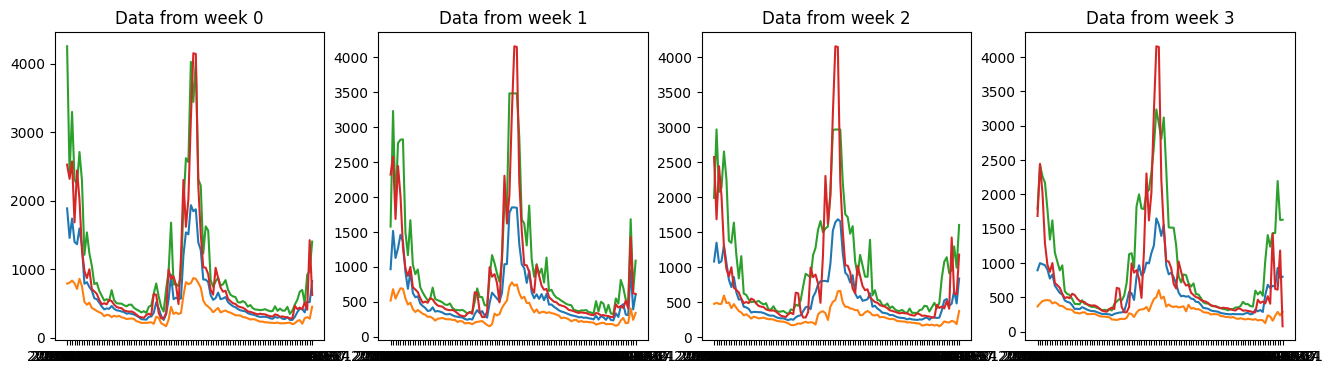

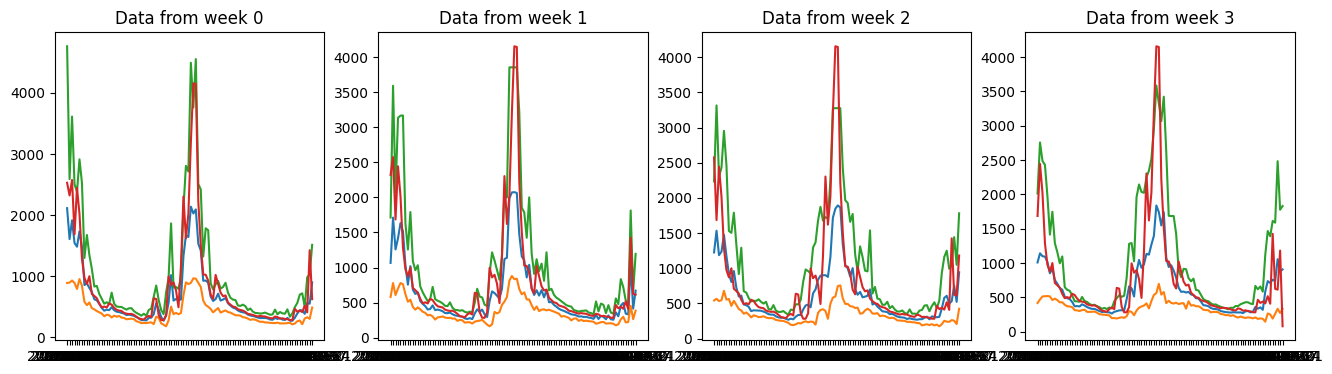

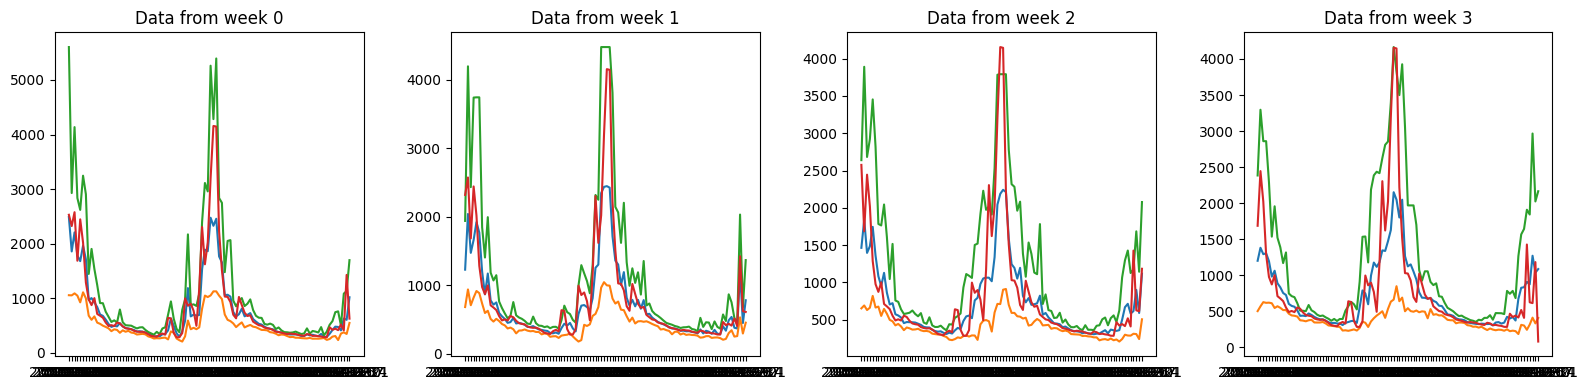

In [24]:
if "qrf_voting" in FINAL_MODELS:
    for confidence_value in location_confidences:

        fig, axes = plt.subplots(1, 4, figsize=(16, 4))

        print(f"Using {confidence_value} location confidence")

        for i in range(NUMBER_OF_WEEK):
            axes[i].plot(preds[confidence_value][i][27600:27700])
            axes[i].set_title(f"Data from week {i}")

    plt.tight_layout()  
    plt.show()

if "gpr" in FINAL_MODELS:

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i in range(NUMBER_OF_WEEK):
        axes[i].plot(pd.DataFrame(preds[i])[27600:27630])
        axes[i].set_title(f"Data from week {i}")
        axes[i].legend()

    plt.tight_layout()  
    plt.show()


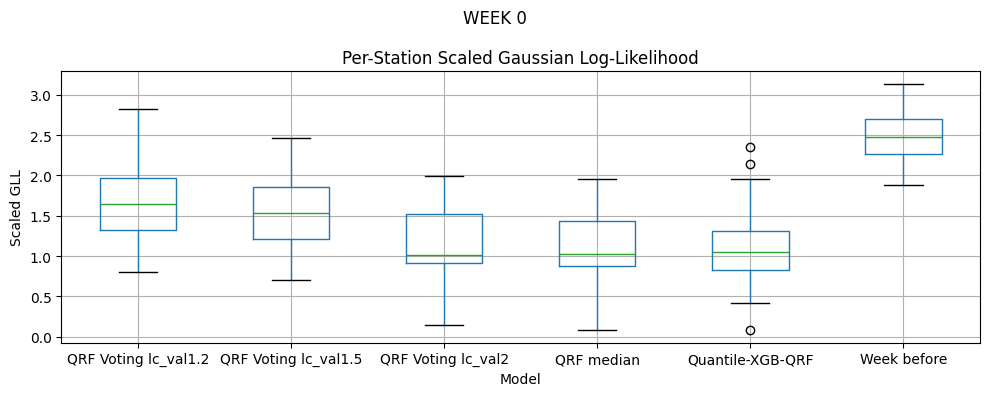

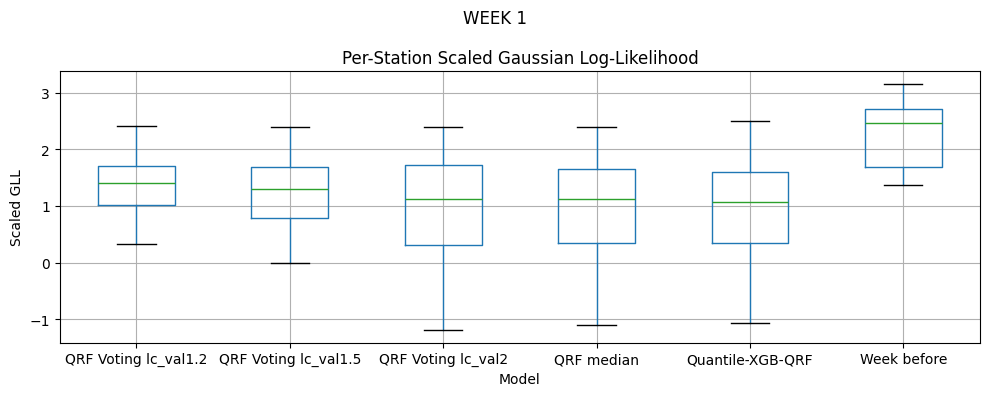

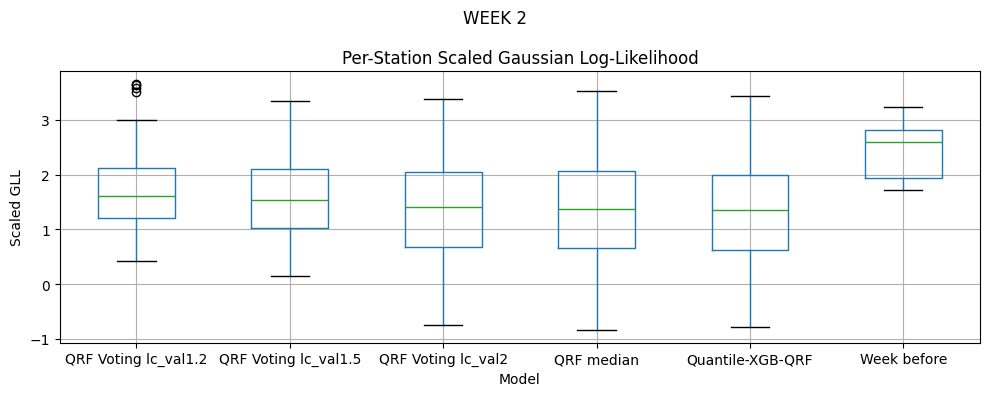

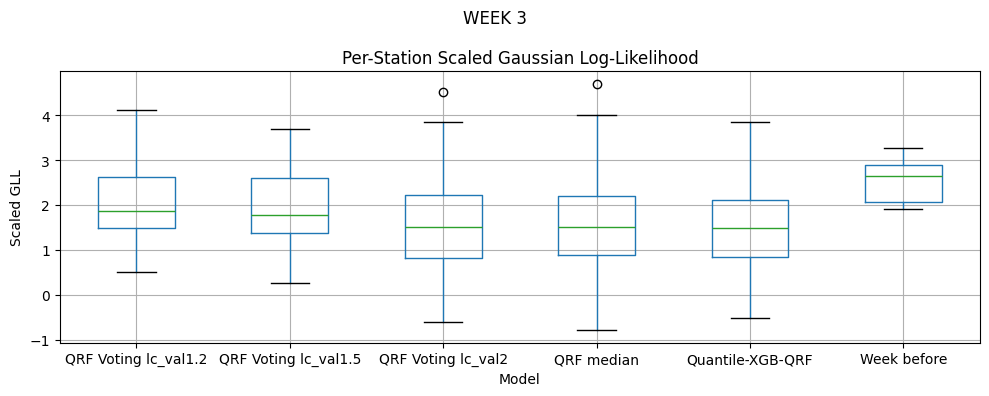

In [25]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"]).fillna(0)

predictions = []

if "chained_qrf" in FINAL_MODELS:
    y_preds_chained_qrf = chained_qrf.predict(X_train_eval, quantiles=[0.1,0.5, 0.9])

    for i in range(NUMBER_OF_WEEK):
        y_pis_qrf = np.stack([y_preds_chained_qrf[i][:,0], y_preds_chained_qrf[i][:,2]], axis=1)
        predictions.append({"model": "Chained QRF",
                            "prediction": y_preds_chained_qrf[i][:,1],
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})
        
# if "specialized_qrf" in FINAL_MODELS:
#     y_preds_specialized_qrf = specialized_qrf.predict(X_train_eval)

#     for i in range(NUMBER_OF_WEEK):
#         y_pis_qrf = np.stack([y_preds_specialized_qrf[i][0.05], y_preds_specialized_qrf[i][0.95]], axis=1)
#         predictions.append({"model": "Specialized QRF",
#                             "prediction": y_preds_specialized_qrf[i][0.5],
#                             "dataset":"train",
#                             "stations": y_train_stations,
#                             "prediction_interval": y_pis_qrf})

for i in range(NUMBER_OF_WEEK):
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append({"model": "Week before", "prediction": baseline_day_before, "dataset":"train", "stations": y_train_stations, "prediction_interval": None})
    
    # if "qrf_bagging" in FINAL_MODELS:
    #     y_pred_qrf_bagging = np.mean([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], axis=0)
    #     y_pis_qrf_bagging = np.stack([np.quantile([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], 0.05, axis=0),
    #                                 np.quantile([est.predict(X_train_eval) for est in qrf_bagging[i].estimators_], 0.95, axis=0)], axis=1)

    #     predictions.append({"model": "QRF bagging",
    #                             "prediction": y_pred_qrf_bagging,
    #                             "dataset":"train",
    #                             "stations": y_train_stations,
    #                             "prediction_interval": y_pis_qrf_bagging})
    if "qrf" in FINAL_MODELS:
        if USE_ONLY_BEST_FEATURES:
            X_train_eval_qrf = X_train_eval[BEST_FEATURES]
        else:
            X_train_eval_qrf = X_train_eval.copy()


        if USE_CORRELATED_FEATURES:
            X_train_eval_qrf = X_train_eval[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"]]

        y_pred_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[0.5], aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[ALPHA/2, 1-ALPHA/2])
        predictions.append({"model": "QRF median",
                            "prediction": y_pred_qrf,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})

    if "qrf_voting" in FINAL_MODELS:

        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_qrf_voting = y_preds_voting["mean"]
            y_pis_qrf_voting = np.stack([y_preds_voting["lower"],
                                        y_preds_voting["upper"]], axis=1)

            predictions.append({"model": f"QRF Voting lc_val{confidence_value}",
                                    "prediction": y_pred_qrf_voting,
                                    "dataset":"train",
                                    "stations": y_train_stations,
                                    "prediction_interval": y_pis_qrf_voting})
    if "gpr" in FINAL_MODELS:

        y_preds_gpr = preds[i]
        y_pred_qrf_voting = y_preds_gpr["mean"]
        y_pis_qrf_voting = np.stack([y_preds_gpr["lower"],
                                    y_preds_gpr["upper"]], axis=1)

        predictions.append({"model": f"GPR",
                                "prediction": y_pred_qrf_voting,
                                "dataset":"train",
                                "stations": y_train_stations,
                                "prediction_interval": y_pis_qrf_voting})

    if "quantile_xgb_qrf" in FINAL_MODELS:

        y_pred_xgb_qrf = quantile_xgb_qrf_models[i].predict(X_train_eval)

        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        predictions.append(
            {
                "model": "Quantile-XGB-QRF",
                "prediction": y_pred_xgb_qrf[:, 1],
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_interval_xgb_qrf,
            }
        )
    # if "native_xgb_qrf" in FINAL_MODELS:

    #     for i in range(NUMBER_OF_WEEK):
    #         y_pred_xgb_qrf = native_xgb_qrf_models[i].predict(X_train_eval)

    #         y_interval_xgb_qrf = np.stack(
    #             [
    #                 y_pred_xgb_qrf[:, 0],
    #                 y_pred_xgb_qrf[:, 2],
    #             ],
    #             axis=1,
    #         )

    #         predictions.append(
    #             {
    #                 "model": "Native-XGB-QRF",
    #                 "prediction": y_pred_xgb_qrf[:, 1],
    #                 "dataset": "train",
    #                 "stations": y_train_stations,
    #                 "prediction_interval": y_interval_xgb_qrf,
    #             }
    #         )

    if "gbr" in FINAL_MODELS:
        X_train_gbr = X_train.drop(columns=["station_code"])
        y_pred_qrf = gbr[i]["median"].predict(X_train_eval)
        y_pis_qrf = np.stack([gbr[i]["lower"].predict(X_train_eval), gbr[i]["upper"].predict(X_train_eval)], axis=1)
        predictions.append({"model": "GBR",
                            "prediction": y_pred_qrf,
                            "dataset":"train",
                            "stations": y_train_stations,
                            "prediction_interval": y_pis_qrf})
    compare_models_per_station(
        y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood" ,
        title = f"WEEK {i}")

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [26]:

if "chained_qrf" in FINAL_MODELS:
    y_preds_chained_qrf = chained_qrf.predict(X_train_eval, quantiles=[0.05,0.5,0.95])

    for i in range(NUMBER_OF_WEEK):
        y_pis_qrf = np.stack([y_preds_chained_qrf[i][:,0], y_preds_chained_qrf[i][:,2]], axis=1)
        coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
        print(f"Chained QRF coverage of the prediction interval for week {i}: {coverage.mean()}")

# if "specialized_qrf" in FINAL_MODELS:
#     y_preds_spe_qrf = specialized_qrf.predict(X_train_eval)

#     for i in range(NUMBER_OF_WEEK):
#         y_pis_qrf = np.stack([y_preds_spe_qrf[i][0.05], y_preds_spe_qrf[i][0.95]], axis=1)
#         coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
#         print(f"Specialized QRF coverage of the prediction interval for week {i}: {coverage.mean()}")

for i in range(NUMBER_OF_WEEK):

    # if "qrf_bagging" in FINAL_MODELS:
    #     y_pred_qrf_bagging = np.mean([est.predict(X_train_eval, quantiles="mean") for est in qrf_bagging[i].estimators_], axis=0)
    #     y_pis_qrf_bagging = np.mean(np.stack(
    #             [
    #                 [
    #                     est.predict(X_train_eval, quantiles=[ALPHA / 2])
    #                     for est in qrf_bagging[i].estimators_
    #                 ],
    #                 [
    #                     est.predict(X_train_eval, quantiles=[ 1 - ALPHA / 2])
    #                     for est in qrf_bagging[i].estimators_
    #                 ]
    #             ],
    #             axis=1,
    #         ), axis=0)
    #     print(y_pred_qrf_bagging.shape)
    #     print(y_pis_qrf_bagging.shape)
    #     coverage = (y_train[i].values >= y_pis_qrf_bagging[0,:]) & (y_train[i].values <= y_pis_qrf_bagging[1,:])
    #     print(f"Bagging QRF coverage of the prediction interval for week {i}: {coverage.mean()}")
    
    if "gbr" in FINAL_MODELS:
        y_pred_gbr = gbr[i]["median"].predict(X_train_eval)
        y_pis_gbr = np.stack([gbr[i]["lower"].predict(X_train_eval), gbr[i]["upper"].predict(X_train_eval)], axis=1)
        coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")
    
    if "gpr" in FINAL_MODELS:
        y_preds_voting = preds[i]
        y_pred_gbr = y_preds_voting["mean"]
        y_pis_gbr = np.stack([y_preds_voting["lower"], y_preds_voting["upper"]], axis=1)
        coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
        print(f"GPR coverage of the prediction interval for week {i}: {coverage.mean()}")

    if "qrf" in FINAL_MODELS:

        if USE_CORRELATED_FEATURES:
            X_train_eval_qrf = X_train_eval[PERMANENT_FEATURES + correlated_features[f"water_flow_week{i+1}"]]

        y_pred_qrf = qrf[i].predict(X_train_eval_qrf, quantiles="mean", aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[0.05, 0.95])
        coverage = (y_train[i].values >= y_pis_qrf[:,0]) & (y_train[i].values <= y_pis_qrf[:,1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}")

    if "quantile_xgb_qrf" in FINAL_MODELS:
        y_pred_xgb_qrf = quantile_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                quantile_xgb_qrf_models[i].predict(X_train_eval)[:, 0],
                quantile_xgb_qrf_models[i].predict(X_train_eval)[:, 2],
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (
            y_train[i].values <= y_interval_xgb_qrf[:, 1]
        )
        print(
            f"Quantile-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

    if "native_xgb_qrf" in FINAL_MODELS:
        y_pred_xgb_qrf = native_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                native_xgb_qrf_models[i].predict(X_train_eval)[:, 0],
                native_xgb_qrf_models[i].predict(X_train_eval)[:, 2],
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (
            y_train[i].values <= y_interval_xgb_qrf[:, 1]
        )
        print(
            f"Native-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
        
    if "qrf_voting" in FINAL_MODELS:
        for confidence_value in location_confidences:
            y_preds_voting = preds[confidence_value][i]
            y_pred_gbr = y_preds_voting["mean"]
            y_pis_gbr = np.stack([y_preds_voting["lower"], y_preds_voting["upper"]], axis=1)
            coverage = (y_train[i].values >= y_pis_gbr[:,0]) & (y_train[i].values <= y_pis_gbr[:,1])
            print(f"Voting QRF coverage of the prediction interval for week {i}, lc_val {confidence_value}: {coverage.mean()}")

QRF coverage of the prediction interval for week 0: 0.9218828965417659
Quantile-XGB-QRF coverage of the prediction interval for week 0: 0.9078766876037832
Voting QRF coverage of the prediction interval for week 0, lc_val 1.2: 0.8641614323875533
Voting QRF coverage of the prediction interval for week 0, lc_val 1.5: 0.8950256299184175
Voting QRF coverage of the prediction interval for week 0, lc_val 2: 0.9510504656703487
QRF coverage of the prediction interval for week 1: 0.918850624503646
Quantile-XGB-QRF coverage of the prediction interval for week 1: 0.9014511587611003
Voting QRF coverage of the prediction interval for week 1, lc_val 1.2: 0.8491083676268861
Voting QRF coverage of the prediction interval for week 1, lc_val 1.5: 0.8888888888888888
Voting QRF coverage of the prediction interval for week 1, lc_val 2: 0.9514114504367915
QRF coverage of the prediction interval for week 2: 0.9136885423435132
Quantile-XGB-QRF coverage of the prediction interval for week 2: 0.8726445743989604


In [27]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio

pio.renderers.default = "browser"  # Assure l'affichage en Jupyter

if "qrf" in FINAL_MODELS:
    for i in range(4):
        y_pred_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[0.5], aggregate_leaves_first=False)
        y_pis_qrf = qrf[i].predict(X_train_eval_qrf, quantiles=[ALPHA/2, 1-ALPHA/2])
        df_plot = pd.DataFrame()
        df_plot["qrf_mean"] = y_pred_qrf
        df_plot["qrf_low"] = y_pis_qrf[:, 0]
        df_plot["qrf_up"] = y_pis_qrf[:, 1]

        print(y_train[i].values)

        df_plot["y_true"] = y_train[i].values

        print(df_plot.isna().sum())     
        t = list(range(len(df_plot)))

        fig = go.Figure()
        print(df_plot["qrf_up"].shape)
        # Courbes des bornes
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["qrf_up"],
            fill=None, mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Upper Bound'
        ))

        print(df_plot["qrf_low"].shape)
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["qrf_low"],
            fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Lower Bound'
        ))

        print(df_plot["qrf_mean"].shape)
        print(df_plot["y_true"].shape)
        # Courbes des valeurs prédites et réelles
        fig.add_trace(go.Scatter(x=t, y=df_plot["qrf_mean"], mode='lines', name='QRF Mean', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=t, y=df_plot["y_true"], mode='lines', name='True Values', line=dict(color='green')))

        fig.update_layout(
            title=f'QRF Prediction Interval - Week {i+1}',
            xaxis_title='Index', yaxis_title='Value',
            template='plotly_white',
            xaxis=dict(rangeslider=dict(visible=True)),
            hovermode="x unified"
        )

        fig.show()

        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (y_train[i].values <= y_pis_qrf[:, 1])
        print(f"QRF coverage of the prediction interval for week {i}: {coverage.mean():.2%}")


[   8.15          8.19285714   10.04142857 ...  623.63735714  612.15205714
 1181.4999    ]
qrf_mean    0
qrf_low     0
qrf_up      0
y_true      0
dtype: int64
(27702,)
(27702,)
(27702,)
(27702,)
QRF coverage of the prediction interval for week 0: 92.19%
[   8.19285714   10.04142857   10.02714286 ...  612.15205714 1181.4999
   78.80028271]
qrf_mean    0
qrf_low     0
qrf_up      0
y_true      0
dtype: int64
(27702,)
(27702,)
(27702,)
(27702,)
QRF coverage of the prediction interval for week 1: 91.89%
[  10.04142857   10.02714286   48.65714286 ... 1181.4999       78.83872045
   78.83872045]
qrf_mean    0
qrf_low     0
qrf_up      0
y_true      0
dtype: int64
(27702,)
(27702,)
(27702,)
(27702,)
QRF coverage of the prediction interval for week 2: 91.37%
[10.02714286 48.65714286 18.52857143 ... 78.86819706 78.86819706
 78.86819706]
qrf_mean    0
qrf_low     0
qrf_up      0
y_true      0
dtype: int64
(27702,)
(27702,)
(27702,)
(27702,)
QRF coverage of the prediction interval for week 3: 90.

In [28]:
import plotly.graph_objects as go
import pandas as pd
import plotly.io as pio

pio.renderers.default = "browser"  # Assure l'affichage en Jupyter

if "quantile_xgb_qrf" in FINAL_MODELS:
    for i in range(4):
        y_pred_xgb_qrf = quantile_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        df_plot = pd.DataFrame()
        df_plot["xgb_qrf_mean"] = y_pred_xgb_qrf[:, 1]
        df_plot["xgb_qrf_low"] = y_pred_xgb_qrf[:, 0]
        df_plot["xgb_qrf_up"] = y_pred_xgb_qrf[:, 2]

        print(y_train[i].values)

        df_plot["y_true"] = y_train[i].values

        print(df_plot.isna().sum())     
        t = list(range(len(df_plot)))

        fig = go.Figure()
        print(df_plot["xgb_qrf_up"].shape)
        # Courbes des bornes
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_up"],
            fill=None, mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Upper Bound'
        ))

        print(df_plot["xgb_qrf_low"].shape)
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_low"],
            fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Lower Bound'
        ))

        print(df_plot["xgb_qrf_mean"].shape)
        print(df_plot["y_true"].shape)
        # Courbes des valeurs prédites et réelles
        fig.add_trace(go.Scatter(x=t, y=df_plot["xgb_qrf_mean"], mode='lines', name='XGB-QRF Mean', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=t, y=df_plot["y_true"], mode='lines', name='True Values', line=dict(color='green')))

        fig.update_layout(
            title=f'Quantile-XGB-QRF Prediction Interval - Week {i+1}',
            xaxis_title='Index', yaxis_title='Value',
            template='plotly_white',
            xaxis=dict(rangeslider=dict(visible=True)),
            hovermode="x unified"
        )

        fig.show()

        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (y_train[i].values <= y_interval_xgb_qrf[:, 1])
        print(f"Quantile-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean():.2%}")

if "native_xgb_qrf" in FINAL_MODELS:
    for i in range(4):
        y_pred_xgb_qrf = native_xgb_qrf_models[i].predict(X_train_eval)
        y_interval_xgb_qrf = np.stack(
            [
                y_pred_xgb_qrf[:, 0],
                y_pred_xgb_qrf[:, 2],
            ],
            axis=1,
        )

        df_plot = pd.DataFrame()
        df_plot["xgb_qrf_mean"] = y_pred_xgb_qrf[:, 1]
        df_plot["xgb_qrf_low"] = y_pred_xgb_qrf[:, 0]
        df_plot["xgb_qrf_up"] = y_pred_xgb_qrf[:, 2]

        print(y_train[i].values)

        df_plot["y_true"] = y_train[i].values

        print(df_plot.isna().sum())     
        t = list(range(len(df_plot)))

        fig = go.Figure()
        print(df_plot["xgb_qrf_up"].shape)
        # Courbes des bornes
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_up"],
            fill=None, mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Upper Bound'
        ))

        print(df_plot["xgb_qrf_low"].shape)
        fig.add_trace(go.Scatter(
            x=t, y=df_plot["xgb_qrf_low"],
            fill='tonexty', mode='lines', line=dict(color='rgba(255,0,0,0.5)'),
            name='Lower Bound'
        ))

        print(df_plot["xgb_qrf_mean"].shape)
        print(df_plot["y_true"].shape)
        # Courbes des valeurs prédites et réelles
        fig.add_trace(go.Scatter(x=t, y=df_plot["xgb_qrf_mean"], mode='lines', name='XGB-QRF Mean', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=t, y=df_plot["y_true"], mode='lines', name='True Values', line=dict(color='green')))

        fig.update_layout(
            title=f'Native-XGB-QRF Prediction Interval - Week {i+1}',
            xaxis_title='Index', yaxis_title='Value',
            template='plotly_white',
            xaxis=dict(rangeslider=dict(visible=True)),
            hovermode="x unified"
        )

        fig.show()

        coverage = (y_train[i].values >= y_interval_xgb_qrf[:, 0]) & (y_train[i].values <= y_interval_xgb_qrf[:, 1])
        print(f"Native-XGB-QRF coverage of the prediction interval for week {i}: {coverage.mean():.2%}")


[   8.15          8.19285714   10.04142857 ...  623.63735714  612.15205714
 1181.4999    ]
xgb_qrf_mean    0
xgb_qrf_low     0
xgb_qrf_up      0
y_true          0
dtype: int64
(27702,)
(27702,)
(27702,)
(27702,)
Quantile-XGB-QRF coverage of the prediction interval for week 0: 90.79%
[   8.19285714   10.04142857   10.02714286 ...  612.15205714 1181.4999
   78.80028271]
xgb_qrf_mean    0
xgb_qrf_low     0
xgb_qrf_up      0
y_true          0
dtype: int64
(27702,)
(27702,)
(27702,)
(27702,)
Quantile-XGB-QRF coverage of the prediction interval for week 1: 90.15%
[  10.04142857   10.02714286   48.65714286 ... 1181.4999       78.83872045
   78.83872045]
xgb_qrf_mean    0
xgb_qrf_low     0
xgb_qrf_up      0
y_true          0
dtype: int64
(27702,)
(27702,)
(27702,)
(27702,)
Quantile-XGB-QRF coverage of the prediction interval for week 2: 87.26%
[10.02714286 48.65714286 18.52857143 ... 78.86819706 78.86819706
 78.86819706]
xgb_qrf_mean    0
xgb_qrf_low     0
xgb_qrf_up      0
y_true          0
d

## Features importance
### _This section will show how the models handled features to meke their predictions_

# **QRF**

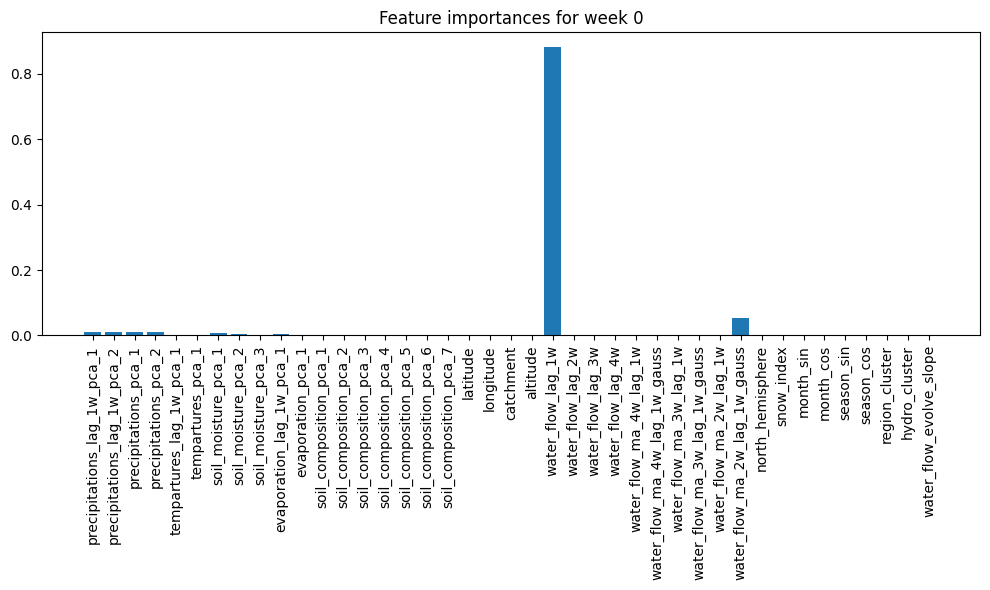

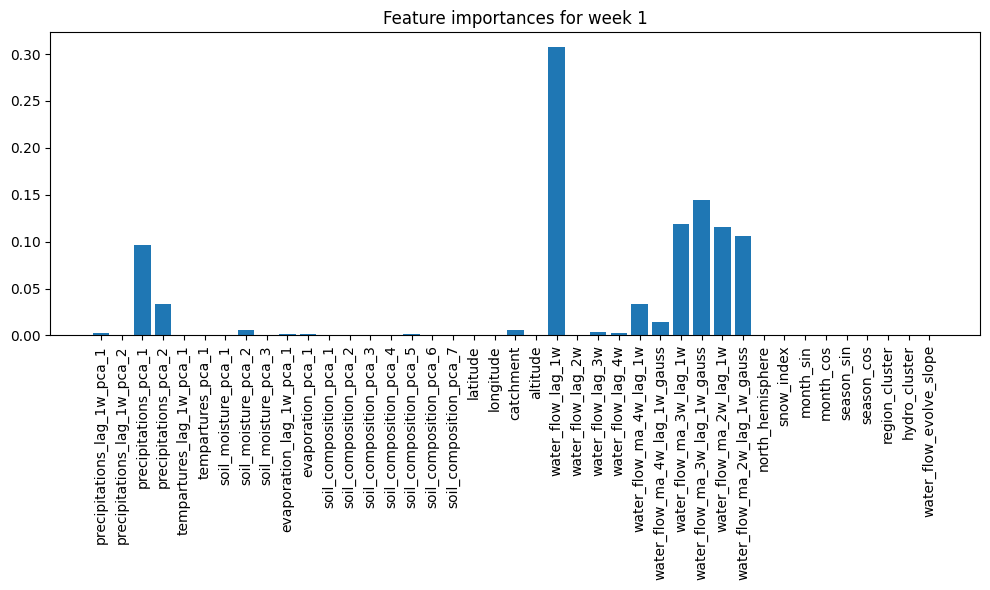

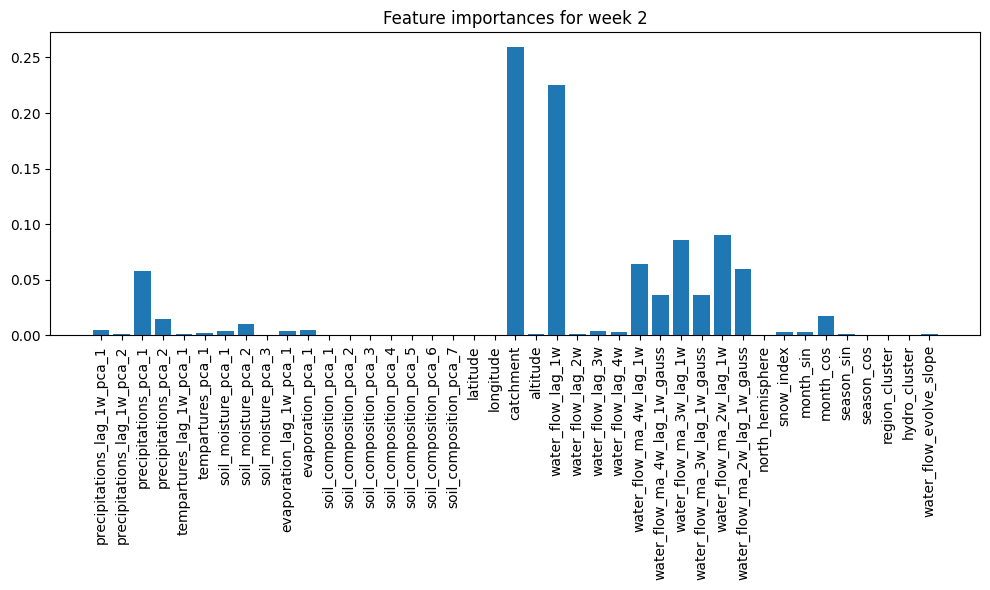

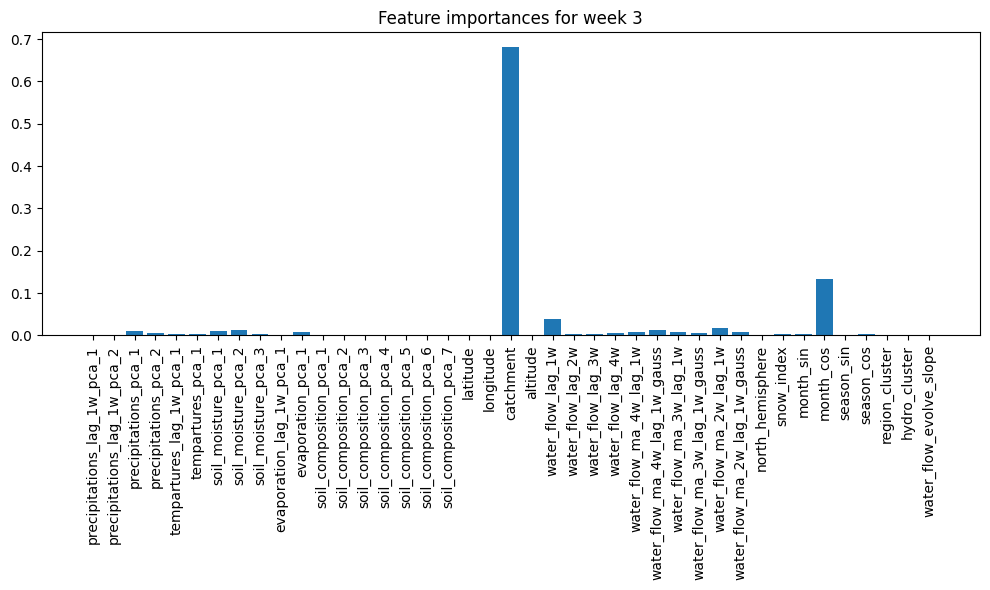

In [29]:
import matplotlib.pyplot as plt
import numpy as np

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        model = qrf[i]
        
        # Vérifier si l'attribut existe
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            
            # Tri et affichage
            plt.figure(figsize=(10, 6))
            plt.title(f"Feature importances for week {i}")
            plt.bar(range(X_train_qrf.shape[1]), importances)
            plt.xticks(range(X_train_qrf.shape[1]), X_train_qrf.columns, rotation=90)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model {i} has no feature_importances_ attribute.")


# **Chained QRF**

In [30]:
import matplotlib.pyplot as plt
import numpy as np

if "chained_qrf" in FINAL_MODELS:
    
    for i in range(NUMBER_OF_WEEK):
        model = chained_qrf.models[i]
        # Vérifier si l'attribut existe
        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            # indices = np.argsort(importances)[::-1]
            # Tri et affichage
            plt.figure(figsize=(10, 6))
            plt.title(f"Feature importances for week {i}")
            plt.bar(range(len(importances)), importances)
            plt.xticks(range(len(importances)), qrf_features[i], rotation=90)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Model {i} has no feature_importances_ attribute.")


# **Voting QRF**

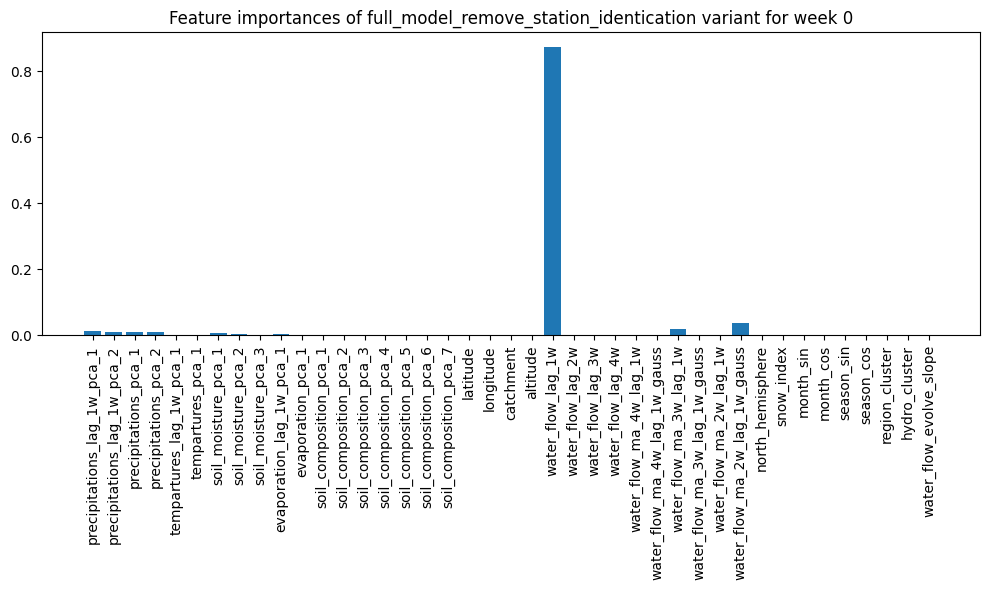

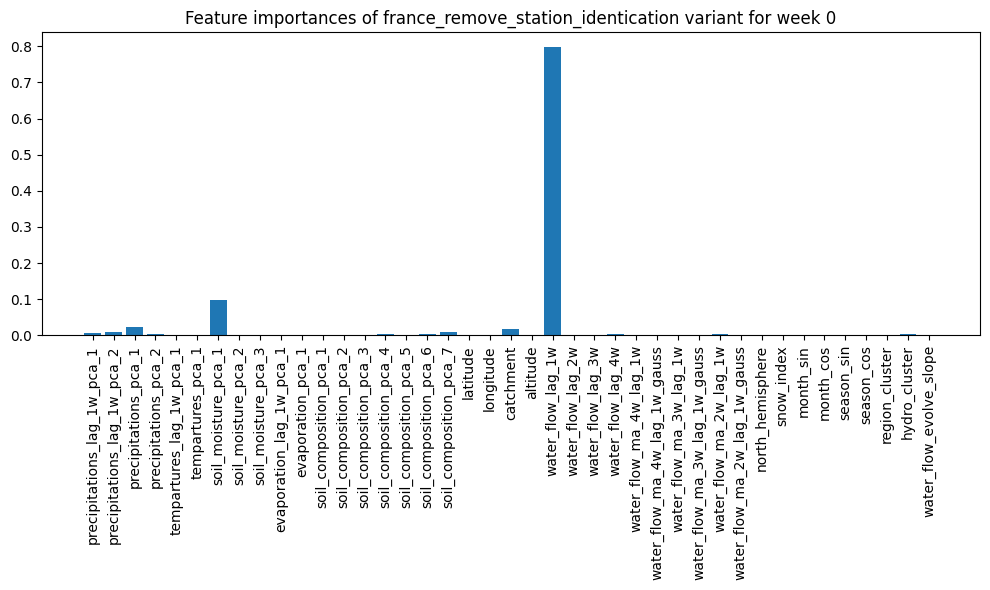

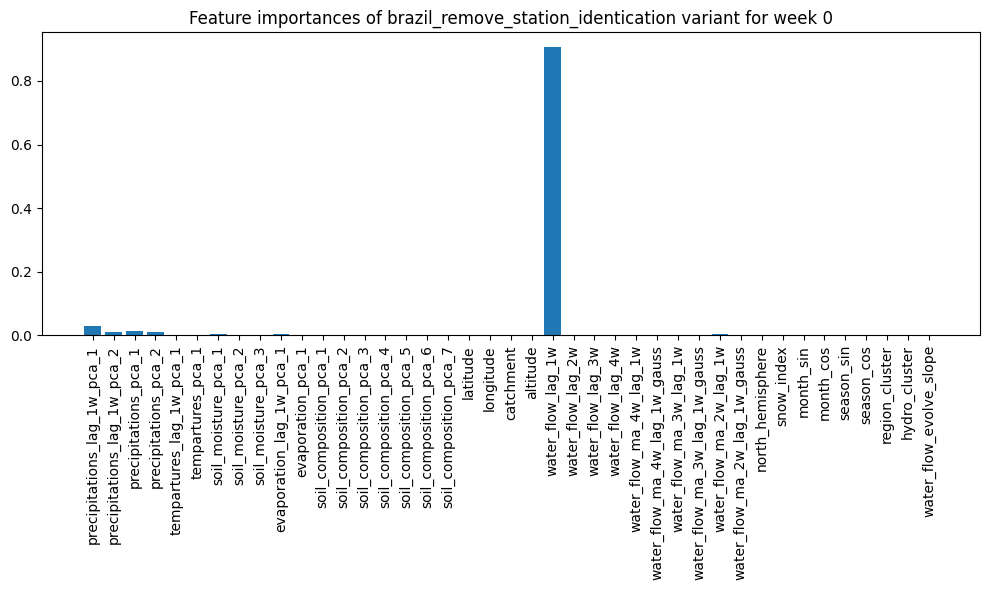

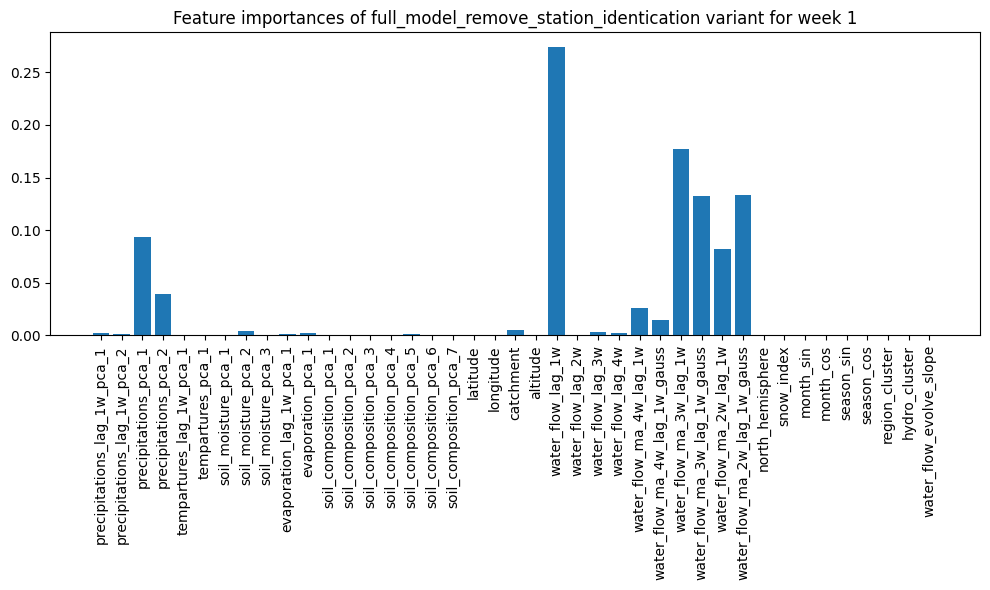

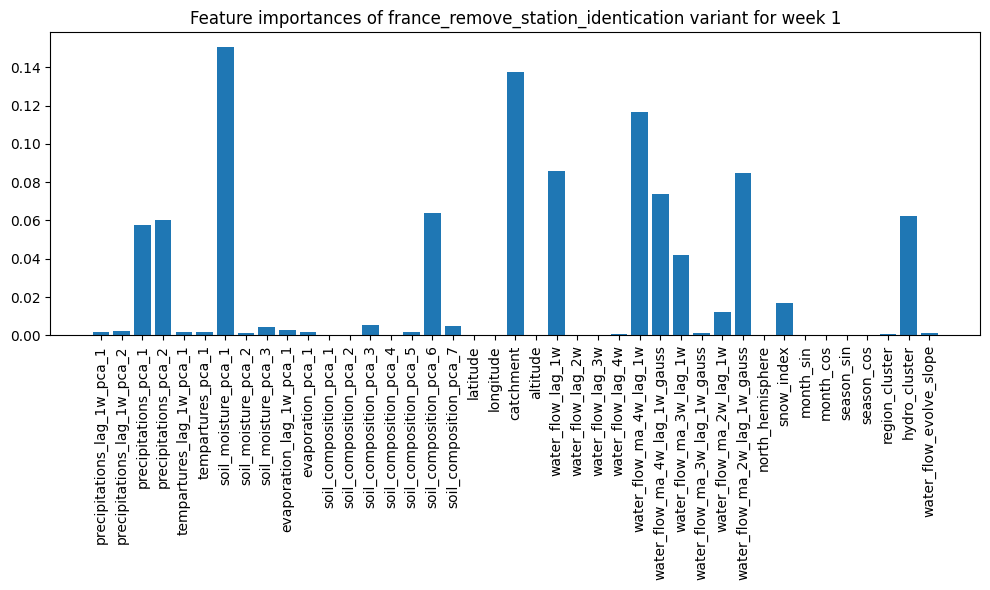

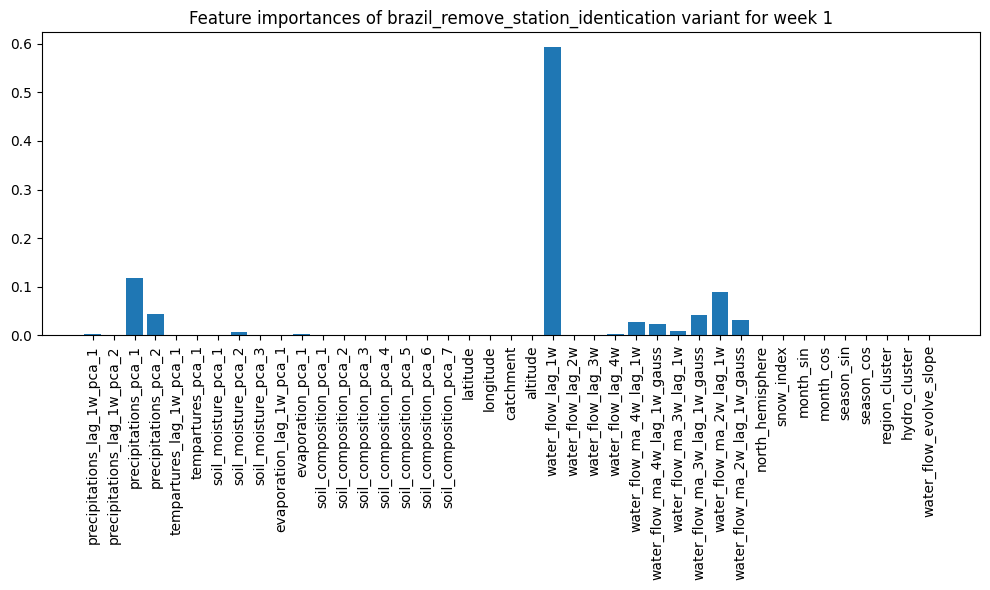

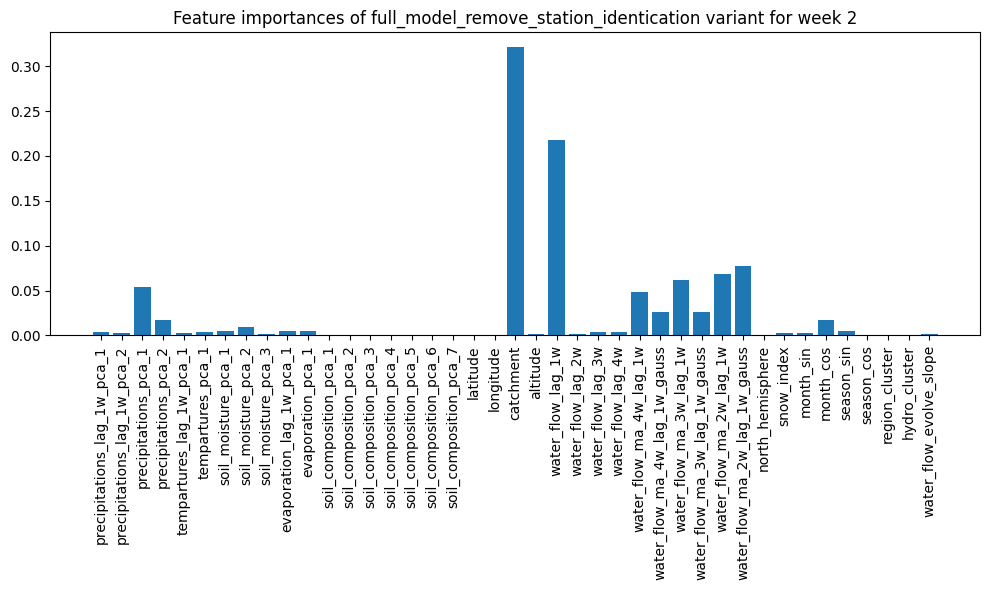

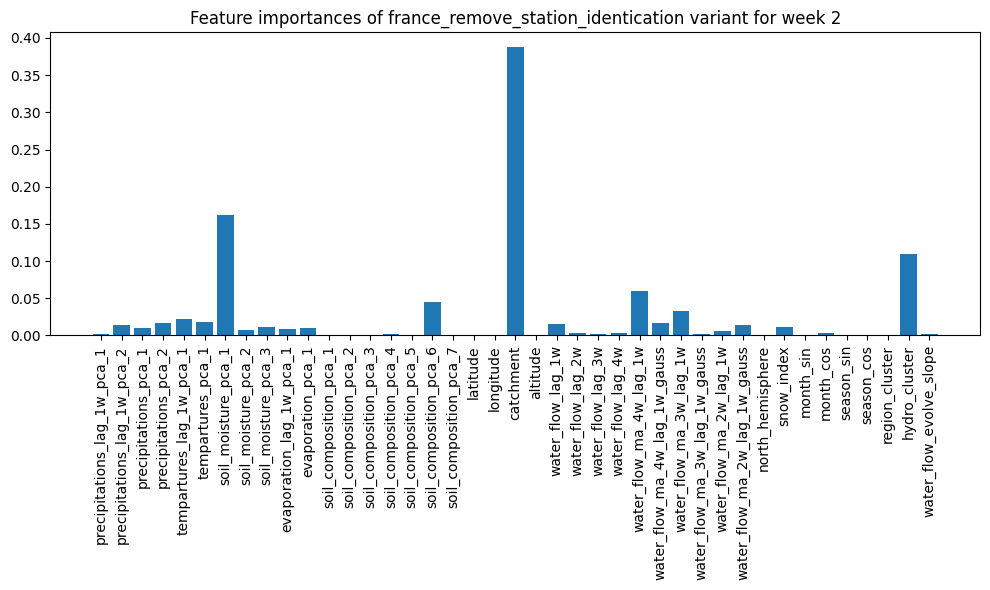

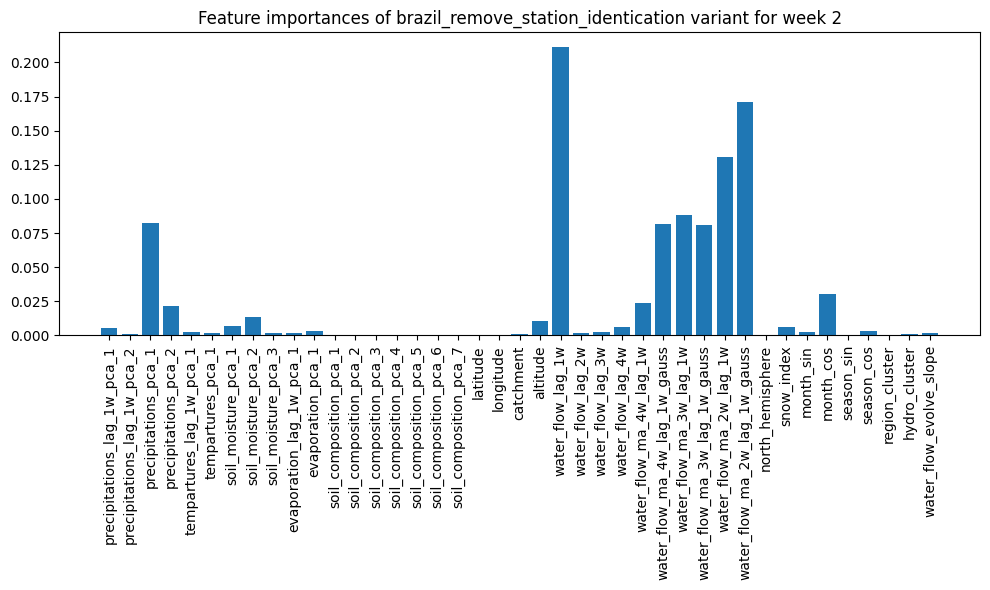

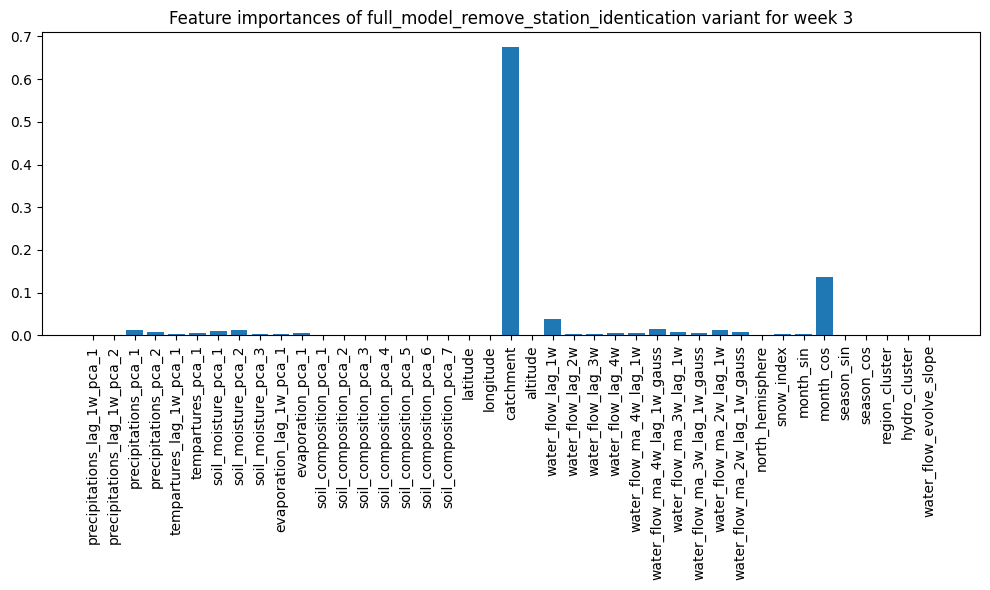

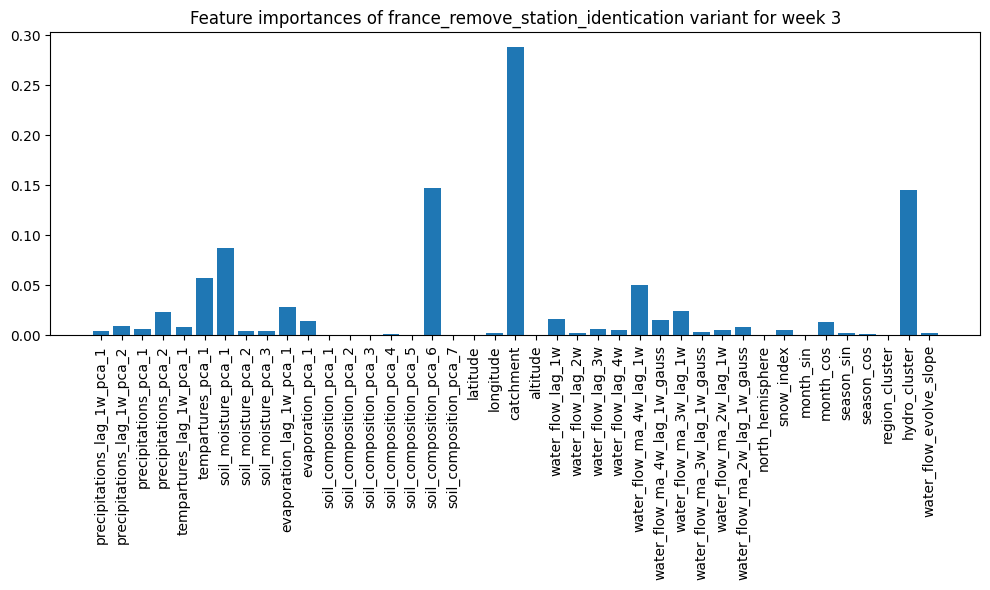

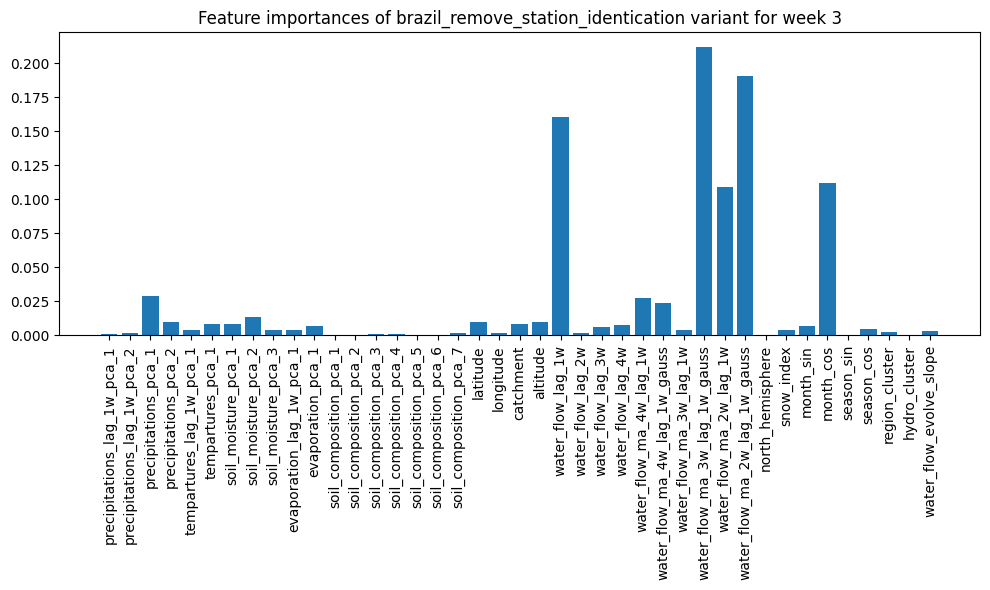

In [31]:
import matplotlib.pyplot as plt
import numpy as np

if "qrf_voting" in FINAL_MODELS:
    
    for i in range(NUMBER_OF_WEEK):
        for variant in VARIANTS:
            model = qrf_voting[i].models[variant]

            # Vérifier si l'attribut existe
            if hasattr(model, "feature_importances_"):
                importances = model.feature_importances_
                # indices = np.argsort(importances)[::-1]
                # Tri et affichage
                plt.figure(figsize=(10, 6))
                plt.title(f"Feature importances of {variant} variant for week {i}")
                plt.bar(range(len(importances)), importances)

                if "remove_station_identication" in variant:
                    plt.xticks(range(len(importances)), X_train_qrf_voting.drop(columns=["station_code"]), rotation=90)
                else:
                    plt.xticks(range(len(importances)), X_train_qrf_voting, rotation=90)
                plt.tight_layout()
                plt.show()
            else:
                print(f"Model {i} has no feature_importances_ attribute.")
